In [1]:
#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score,StratifiedKFold,KFold,train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna
import tqdm
import joblib
import shap
pd.set_option("display.max_columns",70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
sns.set_palette("Set2")


In [7]:
train=pd.read_csv("train_dataset.csv")
test=pd.read_csv("x_test.csv")

In [8]:
df_train=train.copy()
df_test=test.copy()

In [9]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [10]:
train

Year_Factor State_Factor building_class  \
0                1      State_1     Commercial   
1                1      State_1     Commercial   
2                1      State_1     Commercial   
3                1      State_1     Commercial   
4                1      State_1     Commercial   
...            ...          ...            ...   
75752            6     State_11     Commercial   
75753            6     State_11    Residential   
75754            6     State_11     Commercial   
75755            6     State_11     Commercial   
75756            6     State_11    Residential   

                                   facility_type  floor_area  year_built  \
0                   Grocery_store_or_food_market     61242.0      1942.0   
1      Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                           Retail_Enclosed_mall    280025.0      1951.0   
3                      Education_Other_classroom     55325.0      1980.0   
4                      Warehouse_Nonrefrigerated     66000.0      1985.0   
...                                          ...         ...         ...   
75752                       Office_Uncategorized     20410.0      1995.0   
75753                        5plus_Unit_Building     40489.0      1910.0   
75754                           Commercial_Other     28072.0      1917.0   
75755                           Commercial_Other     53575.0      2012.0   
75756                         2to4_Unit_Building     23888.0      1974.0   

       energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  \
0                    11.0        2.4                36         50.500000   
1                    45.0        1.8                36         50.500000   
2                    97.0        1.8                36         50.500000   
3                    46.0        1.8                36         50.500000   
4                   100.0        2.4                36         50.500000   
...                   ...        ...               ...               ...   
75752                 8.0       36.6                28         43.451613   
75753                98.0       36.6                28         43.451613   
75754                 NaN       36.6                26         36.612903   
75755                 NaN       36.6                26         36.612903   
75756                51.0       36.6                27         36.935484   

       january_max_temp  february_min_temp  february_avg_temp  \
0                    68                 35          50.589286   
1                    68                 35          50.589286   
2                    68                 35          50.589286   
3                    68                 35          50.589286   
4                    68                 35          50.589286   
...                 ...                ...                ...   
75752                56                 34          47.672414   
75753                56                 34          47.672414   
75754                48                 30          41.637931   
75755                48                 30          41.637931   
75756                51                 29          42.172414   

       february_max_temp  march_min_temp  march_avg_temp  march_max_temp  \
0                     73              40       53.693548              80   
1                     73              40       53.693548              80   
2                     73              40       53.693548              80   
3                     73              40       53.693548              80   
4                     73              40       53.693548              80   
...                  ...             ...             ...             ...   
75752                 64              35       49.354839              71   
75753                 64              35       49.354839              71   
75754                 58              29       41.338710              62   
75755                 58              2

EDA- Understanding Features

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [12]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [13]:
print([col for col in df_train if df_train[col].nunique()==1])
print([col for col in df_test if df_test[col].nunique()==1])

[]
['Year_Factor', 'days_above_110F']


In [14]:
df_train.isnull().sum()*100/len(df_train)

Year_Factor                   0.000000
State_Factor                  0.000000
building_class                0.000000
facility_type                 0.000000
floor_area                    0.000000
                               ...    
direction_peak_wind_speed    55.190939
max_wind_speed               54.228652
days_with_fog                60.451179
site_eui                      0.000000
id                            0.000000
Length: 64, dtype: float64

In [15]:
df_test.isnull().sum()*100/len(df_test)

Year_Factor                   0.000000
State_Factor                  0.000000
building_class                0.000000
facility_type                 0.000000
floor_area                    0.000000
                               ...    
direction_max_wind_speed     88.356517
direction_peak_wind_speed    88.356517
max_wind_speed               88.356517
days_with_fog                93.941267
id                            0.000000
Length: 63, dtype: float64

In [16]:
df_test[['Year_Factor', 'days_above_110F']]

Year_Factor  days_above_110F
0               7                0
1               7                0
2               7                0
3               7                0
4               7                0
...           ...              ...
9700            7                0
9701            7                0
9702            7                0
9703            7                0
9704            7                0

[9705 rows x 2 columns]

Observations:
1) Data contains 75757 samples and 64 features. We have 3 categorical and rest numerical features. Target is numerical.
2)  year_built, energy_star_rating, direction_max_wind_speed, direction_peak_wind_speed, max_wind_speed, days_with_fog variables have NA values.

3) There are no duplicates in individual dataset, however there might be duplicates in the combined version

4) there are no constant columns in train dataset, but test dataset has 2 constant columns

combine the datasets for the visualizations

In [17]:
test['site_eui'] = np.nan #63
test['dataset'] = 'test'
train['dataset'] = 'train'

df_all = pd.concat([train, test], axis=0, ignore_index=True)

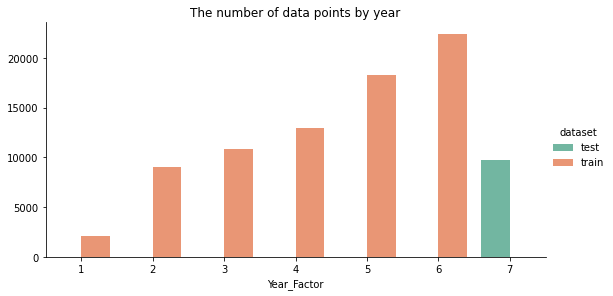

In [18]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

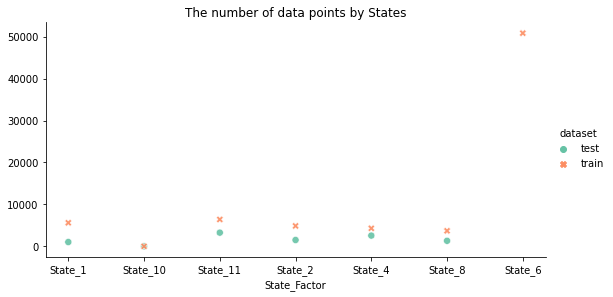

In [19]:
ax = sns.relplot(x='State_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by States",
    ylabel=None)

 The type of building and state could be important factors in determining EUI.

Text(0.5, 0, '')

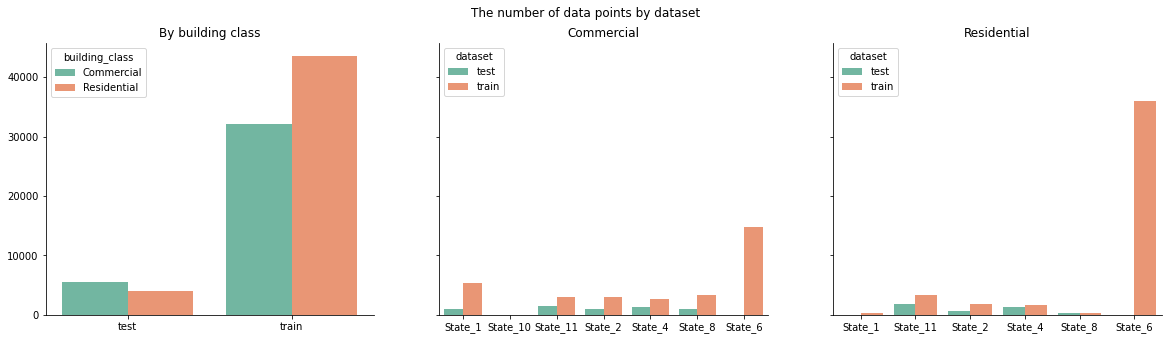

In [20]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

All facility types are present in both datasets. Almost 90% of residential Multifamily_uncategorized buildings and 50% of Office_uncategorized are in State_6 of the training set. So State_6 will affect the model learning and prediction.

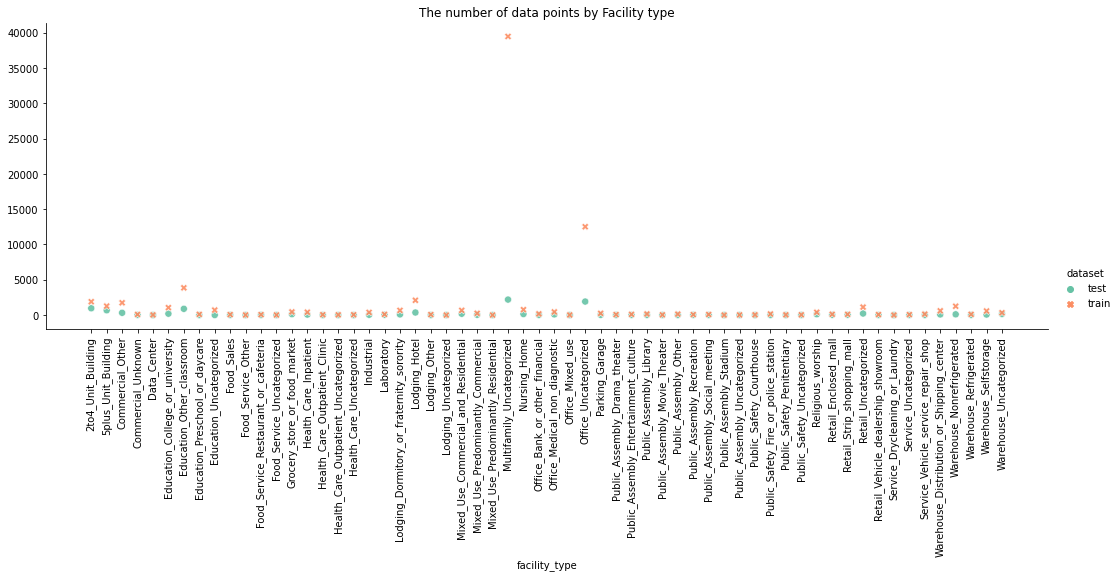

In [21]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

In [22]:
df_all['year_built'].value_counts().index.sort_values()

Float64Index([   0.0, 1600.0, 1649.0, 1732.0, 1756.0, 1789.0, 1799.0, 1800.0,
              1811.0, 1815.0,
              ...
              2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
              2015.0, 2016.0],
             dtype='float64', length=183)

The oldest building was built in 1600 and the latest in 2016. The majority of the buildings were built since 1900. There were some 0 and null values.

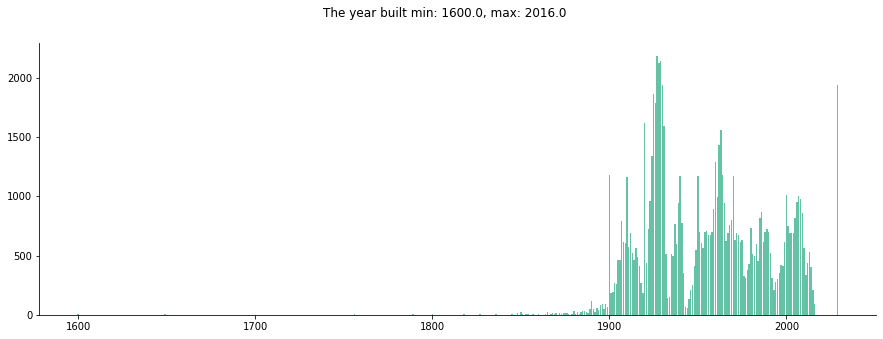

In [23]:
temp = df_all[['year_built']].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)\
            .sort_values('year_built')
fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['year_built'],
           temp['count']
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}");

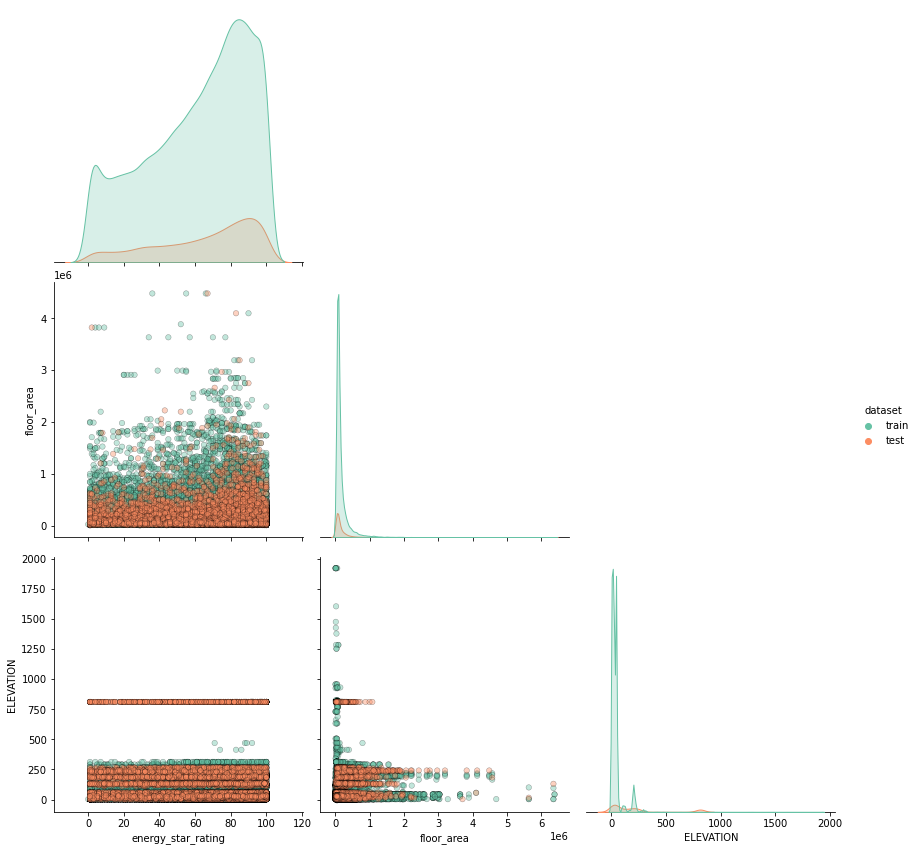

In [24]:
sns.pairplot(df_all,
            vars=['energy_star_rating','floor_area','ELEVATION'], 
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           );

small positive correlation between floor_area and energy_star_rating can be observable.

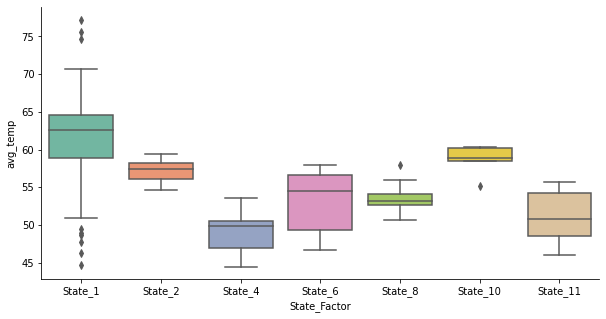

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');



The range of temperatures of State1, State 6, State 11 and State 4 are higher compared to the other states.

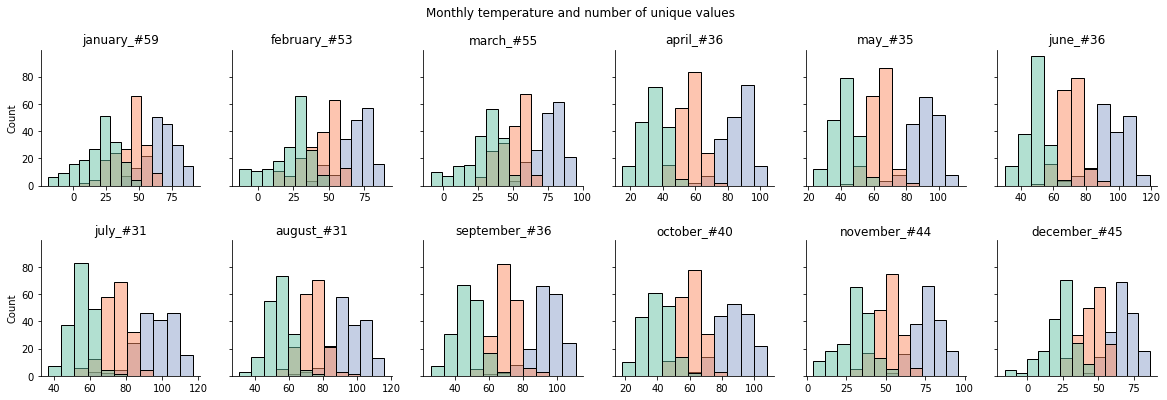

In [26]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

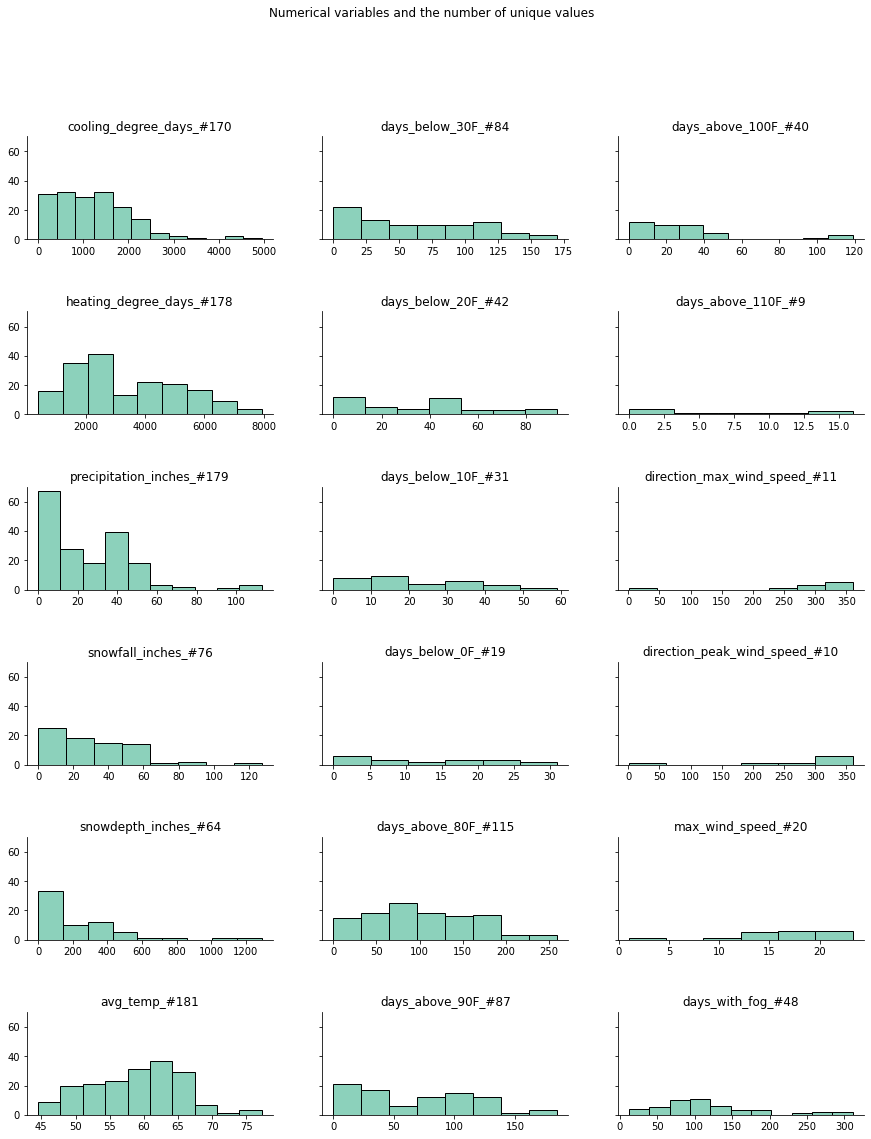

In [27]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

Target Variable Exploration (EUI)

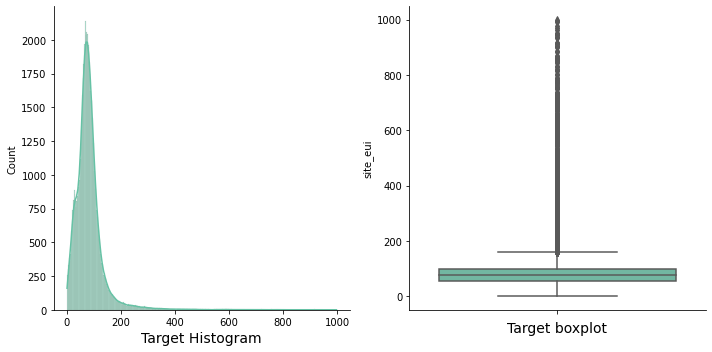

In [28]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout();

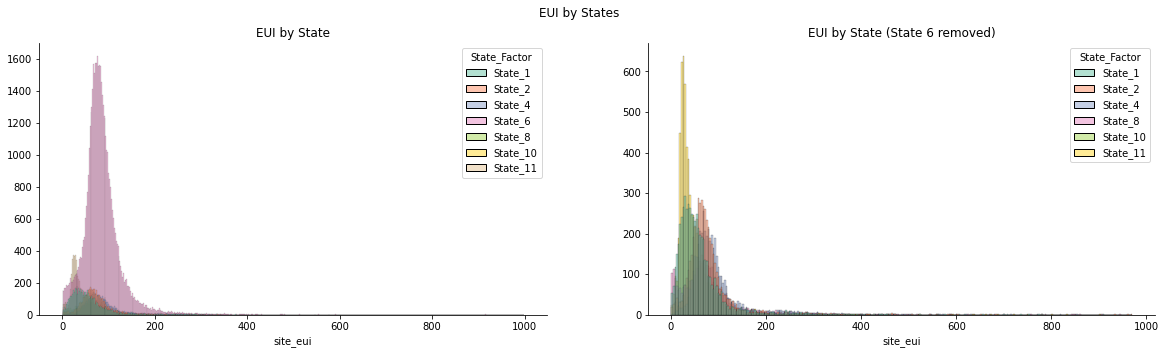

In [29]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

State 11 and 8 have lower EUI level.

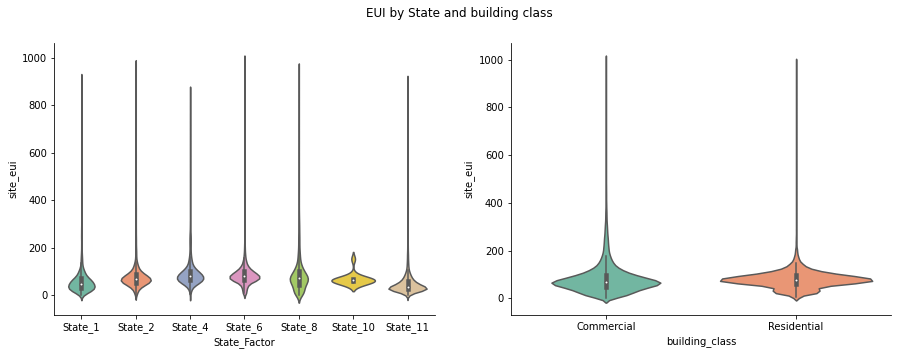

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.violinplot(data=df_all, y='site_eui', x='State_Factor', ax=ax[0])
sns.violinplot(data=df_all, y='site_eui', x='building_class', ax=ax[1]);

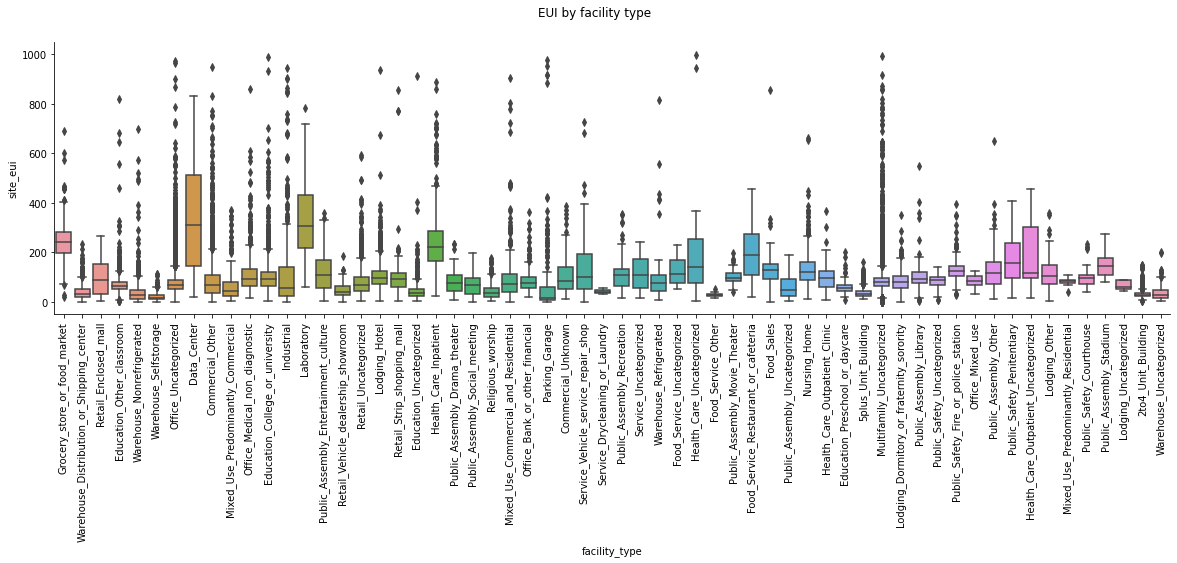

In [31]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Labs and Data Centers have higher EUI compared to the other types of buildings.

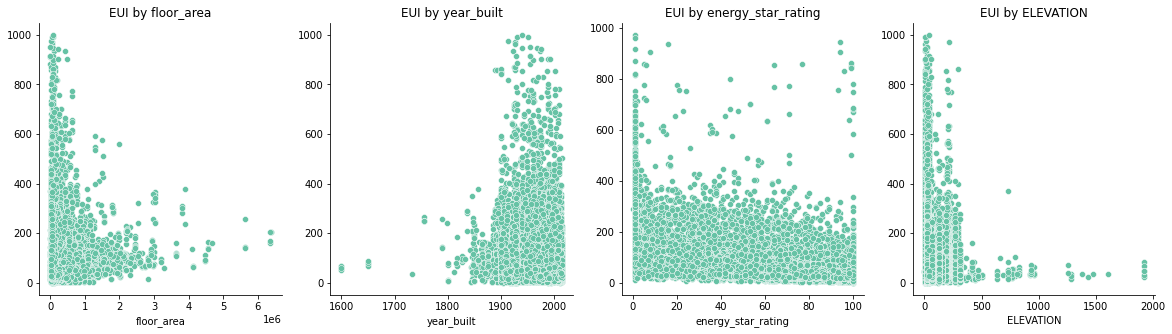

In [32]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

Floor_area is having positive relationship with EUI

 

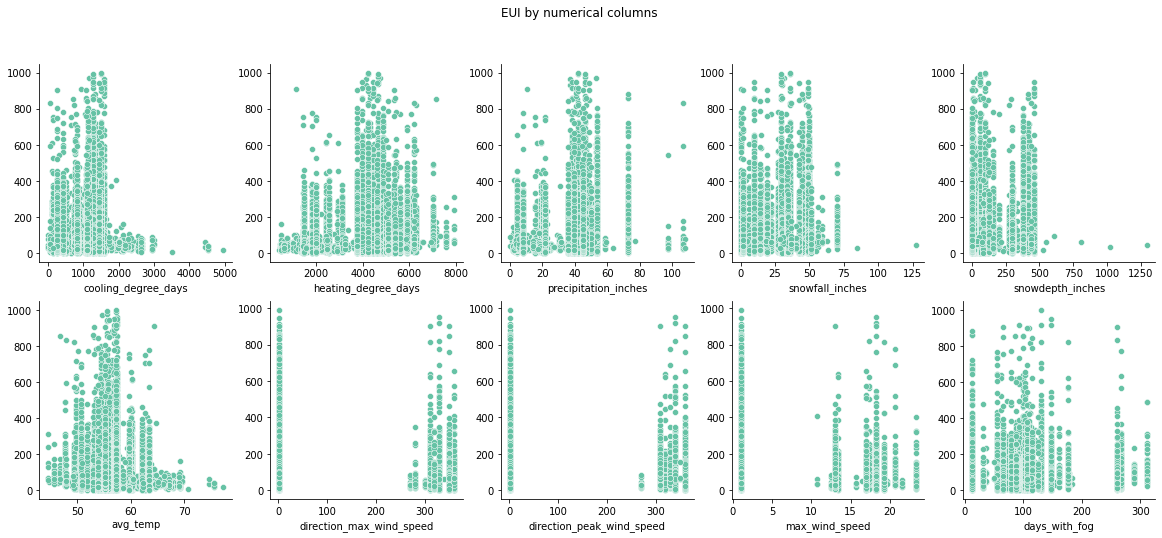

In [33]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);

most data points are in lower number of cooling_degree_days and higher number ofheating_degree_days

No relationship between EUI and the weather related numerical columns 

Categorical variables such as State_Factor, building_class and facility_type might have some correlation with EUI.

State_6 is not present in test set. State 6 removed training data should be tested.

floor_area, energe_star_rating should be included in the modelling to be tested.

Variables with more than 50% NA values should not be imputed (in my opinion) and better to be not included in the training set.

# Preprocessing

Removing duplicates by clubbing similar building data

In [34]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)


In [35]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

In [36]:
cats = ['State_Factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(df_all[col], dummy_na=False)
    for ohe_col in dummies:
        df_all[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [37]:
df_all

Year_Factor State_Factor building_class              facility_type  \
0                3      State_1     Commercial           Commercial_Other   
1                4      State_1     Commercial           Commercial_Other   
2                5      State_1     Commercial           Commercial_Other   
3                7      State_1     Commercial           Commercial_Other   
4                3      State_1     Commercial           Commercial_Other   
...            ...          ...            ...                        ...   
85457            7      State_8    Residential  Multifamily_Uncategorized   
85458            6      State_8    Residential  Multifamily_Uncategorized   
85459            7      State_8    Residential  Multifamily_Uncategorized   
85460            6      State_8    Residential  Multifamily_Uncategorized   
85461            7      State_8    Residential  Multifamily_Uncategorized   

       floor_area  year_built  energy_star_rating  ELEVATION  \
0         10149.0      1931.0                 NaN       45.7   
1         10149.0      1931.0                 NaN      120.4   
2         10149.0      1931.0                 NaN       59.1   
3         10149.0      1931.0                 NaN       59.1   
4         10755.0      1937.0                 NaN        9.1   
...           ...         ...                 ...        ...   
85457    900000.0      1960.0                90.0      130.8   
85458   1179072.0      1959.0                96.0        3.0   
85459   1179072.0      1959.0                92.0      130.8   
85460   1195034.0      1964.0                75.0        3.0   
85461   1195034.0      1964.0                77.0      130.8   

       january_min_temp  january_avg_temp  january_max_temp  \
0                    26         44.516129                64   
1                    41         55.096774                73   
2                    29         51.387097                77   
3                    38         50.596774                64   
4                    22         44.790323                65   
...                 ...               ...               ...   
85457                 2         33.435484                61   
85458                 8         29.827586                62   
85459                 2         33.435484                61   
85460                 8         29.827586                62   
85461                 2         33.435484                61   

       february_min_temp  february_avg_temp  february_max_temp  \
0                     30          49.392857                 69   
1                     42          54.875000                 71   
2                     36          56.803571                 75   
3                     40          54.482143                 66   
4                     25          47.892857                 71   
...                  ...                ...                ...   
85457                 16          37.660714                 73   
85458                  4          33.896552                 62   
85459                 16          37.660714                 73   
85460                  4          33.896552                 62   
85461                 16          37.660714                 73   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                  37       55.967742              77              40   
1                  47       59.032258              76              47   
2                  40       61.435484              85              41   
3                  42       56.935484              77              45   
4                  32       53.112903              79              34   
...               ...             ...             ...             ...   
85457               8       35.935484              69              28   
85458              24       45.967742              79              18   
85459               8       35.935484              69              28   
85460              24       45.96

In [39]:
knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    
    tmp.to_csv('imputer_tmp.csv', index=False)
    df1.to_csv('imputer_df1.csv', index=False)
    joblib.dump(imputer, 'models/knn_imputer.pkl')

else:
    df1 = pd.read_csv('imputer_df1.csv')
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]



In [40]:
cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all[f'te_{col}'] = encoder.fit_transform(df_all[col], df_all[target])

Feature Engineering

Weather based features

In [41]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all.columns if 'temp' in col]

df_all['min_temp'] = df_all[temp].min(axis=1)
df_all['max_temp'] = df_all[temp].max(axis=1)
df_all['avg_temp'] = df_all[temp].mean(axis=1)
df_all['std_temp'] = df_all[temp].std(axis=1)
df_all['skew_temp'] = df_all[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in df_all.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all['min_winter_temp'] = df_all[winter_temp].min(axis=1)
df_all['max_winter_temp'] = df_all[winter_temp].max(axis=1)
df_all['avg_winter_temp'] = df_all[winter_temp].mean(axis=1)
df_all['std_winter_temp'] = df_all[winter_temp].std(axis=1)
df_all['skew_winter_temp'] = df_all[winter_temp].skew(axis=1)
### spring
df_all['min_spring_temp'] = df_all[spring_temp].min(axis=1)
df_all['max_spring_temp'] = df_all[spring_temp].max(axis=1)
df_all['avg_spring_temp'] = df_all[spring_temp].mean(axis=1)
df_all['std_spring_temp'] = df_all[spring_temp].std(axis=1)
df_all['skew_spring_temp'] = df_all[spring_temp].skew(axis=1)
### summer
df_all['min_summer_temp'] = df_all[summer_temp].min(axis=1)
df_all['max_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['avg_summer_temp'] = df_all[summer_temp].mean(axis=1)
df_all['std_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['skew_summer_temp'] = df_all[summer_temp].max(axis=1)
## autumn
df_all['min_autumn_temp'] = df_all[autumn_temp].min(axis=1)
df_all['max_autumn_temp'] = df_all[autumn_temp].max(axis=1)
df_all['avg_autumn_temp'] = df_all[autumn_temp].mean(axis=1)
df_all['std_autumn_temp'] = df_all[autumn_temp].std(axis=1)
df_all['skew_autumn_temp'] = df_all[autumn_temp].skew(axis=1)

In [42]:
df_all['month_cooling_degree_days'] = df_all['cooling_degree_days']/12
df_all['month_heating_degree_days'] = df_all['heating_degree_days']/12

Building based feature:

In [43]:
# total area
df_all['building_area'] = df_all['floor_area'] * df_all['ELEVATION']
# rating energy by floor
df_all['floor_energy_star_rating'] = df_all['energy_star_rating']/df_all['ELEVATION']

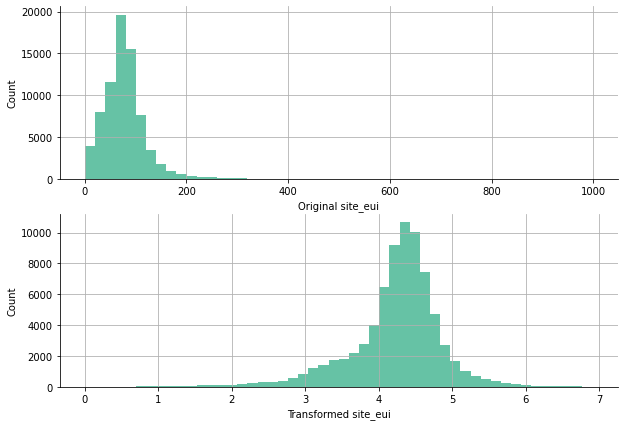

In [44]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

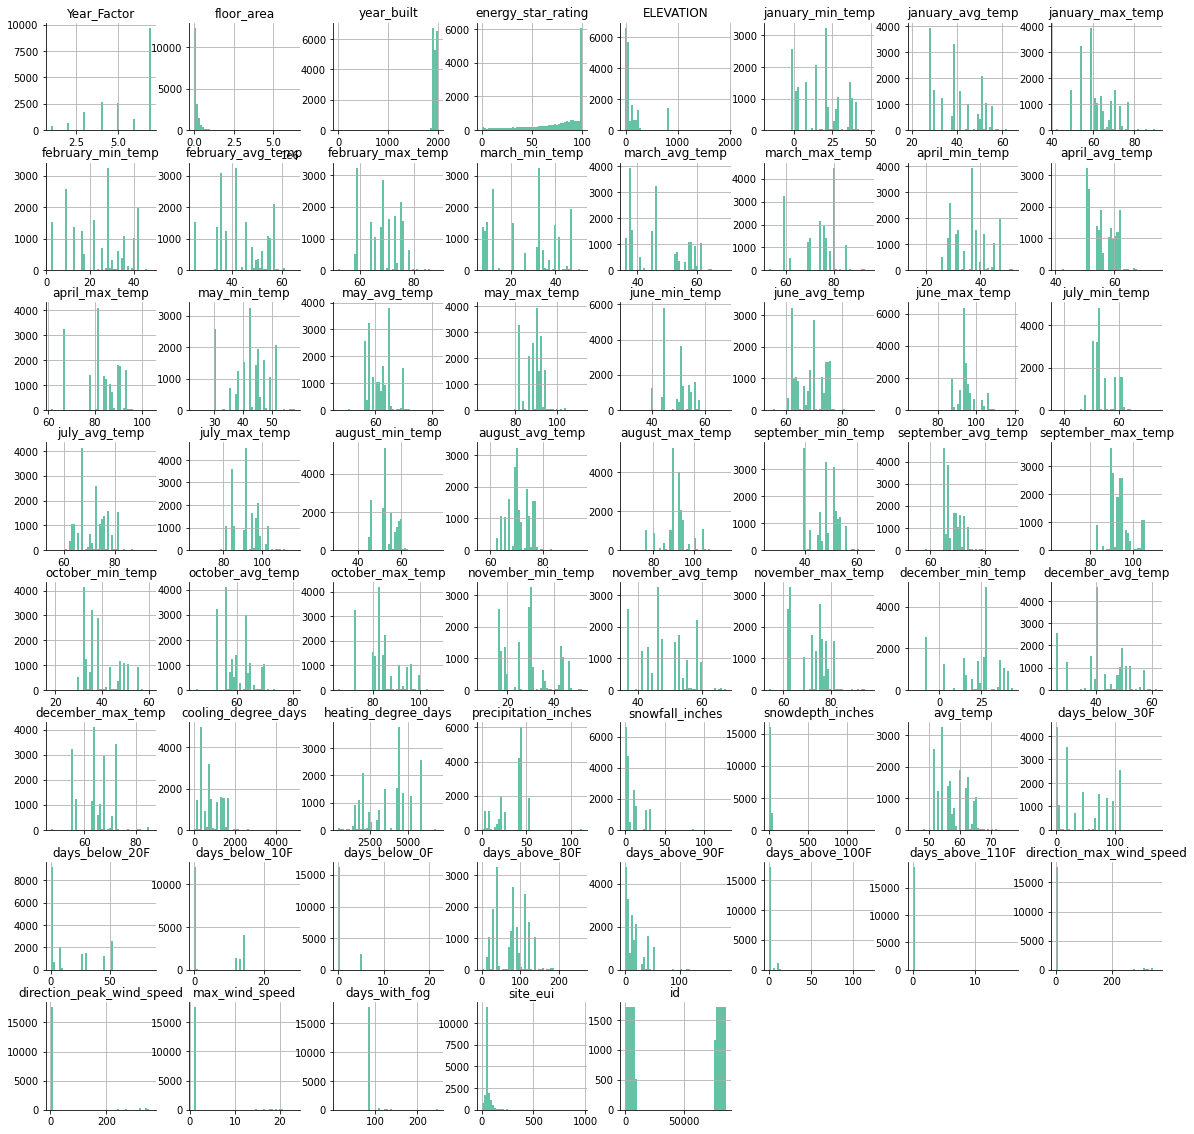

In [45]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [46]:
df_all[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F     42.090675
year_built         -19.369262
snowdepth_inches    16.423086
days_above_100F     11.889837
days_with_fog        7.809137
dtype: float64

In [47]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all[var] = np.where(df_all[var]==0, 0, 1)

In [48]:
saved = False
if saved:
    !pip install pickle5 --quiet
    import pickle5 as pickle
    data_path = 'feature_transformed_set.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    df_all.to_pickle('feature_transformed_set.pkl')

In [49]:
df_all.shape

(85462, 165)

In [50]:
df_all.head()

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0          3.0     10149.0      1931.0               100.0       45.7   
1          4.0     10149.0      1931.0               100.0      120.4   
2          5.0     10149.0      1931.0               100.0       59.1   
3          7.0     10149.0      1931.0               100.0       59.1   
4          3.0     10755.0      1937.0               100.0        9.1   

   january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
0              26.0         44.516129              64.0               30.0   
1              41.0         55.096774              73.0               42.0   
2              29.0         51.387097              77.0               36.0   
3              38.0         50.596774              64.0               40.0   
4              22.0         44.790323              65.0               25.0   

   february_avg_temp  february_max_temp  march_min_temp  march_avg_temp  \
0          49.392857               69.0            37.0       55.967742   
1          54.875000               71.0            47.0       59.032258   
2          56.803571               75.0            40.0       61.435484   
3          54.482143               66.0            42.0       56.935484   
4          47.892857               71.0            32.0       53.112903   

   march_max_temp  april_min_temp  april_avg_temp  april_max_temp  \
0            77.0            40.0       61.783333            90.0   
1            76.0            47.0       60.100000            90.0   
2            85.0            41.0       60.966667            91.0   
3            77.0            45.0       58.450000            78.0   
4            79.0            34.0       58.866667            87.0   

   may_min_temp  may_avg_temp  may_max_temp  june_min_temp  june_avg_temp  \
0          45.0     65.129032          91.0           52.0      70.016667   
1          51.0     63.483871          92.0           52.0      64.250000   
2          45.0     62.887097          90.0           55.0      72.983333   
3          49.0     60.903226          87.0           51.0      63.150000   
4          35.0     62.096774          91.0           44.0      66.283333   

   june_max_temp  july_min_temp  july_avg_temp  july_max_temp  \
0          104.0           52.0      71.387097          102.0   
1           87.0           53.0      66.903226           90.0   
2          106.0           60.0      74.516129          103.0   
3           97.0           53.0      64.258065           85.0   
4           99.0           48.0      65.693548           91.0   

   august_min_temp  august_avg_temp  august_max_temp  september_min_temp  \
0             54.0        71.322581             97.0                47.0   
1             57.0        67.016129             80.0                56.0   
2             58.0        74.774194            104.0                53.0   
3             53.0        65.854839             88.0                54.0   
4             45.0        67.080645             92.0                42.0   

   september_avg_temp  september_max_temp  october_min_temp  october_avg_temp  \
0           69.133333                98.0              43.0         61.000000   
1           68.383333                83.0              55.0         68.661290   
2           73.583333               105.0              49.0         69.580645   
3           69.766667               104.0              48.0         64.193548   
4           65.950000                96.0              35.0         56.967742   

   october_max_temp  ...  building_class     facility_type  dataset  \
0              84.0  ...      Commercial  Commercial_Other    train   
1              95.0  ...      Commercial  Commercial_Other    train   
2              96.0  ...      Commercial  Commercial_Other    train   
3              91.0  ...      Commercial  Commercial_Other     test   
4              85.0  ...      Commercial  Commercial_Other    train   

    

In [51]:
cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']

# typecasting numerical features
for col in df_all.drop(columns=cats + ['dataset', 'id', 'site_eui']).columns:
    df_all[col] = df_all[col].astype('float64')

In [52]:
df_all.drop(columns=cats)

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0              3.0     10149.0      1931.0               100.0       45.7   
1              4.0     10149.0      1931.0               100.0      120.4   
2              5.0     10149.0      1931.0               100.0       59.1   
3              7.0     10149.0      1931.0               100.0       59.1   
4              3.0     10755.0      1937.0               100.0        9.1   
...            ...         ...         ...                 ...        ...   
85457          NaN         NaN         NaN                 NaN        NaN   
85458          NaN         NaN         NaN                 NaN        NaN   
85459          NaN         NaN         NaN                 NaN        NaN   
85460          NaN         NaN         NaN                 NaN        NaN   
85461          NaN         NaN         NaN                 NaN        NaN   

       january_min_temp  january_avg_temp  january_max_temp  \
0                  26.0         44.516129              64.0   
1                  41.0         55.096774              73.0   
2                  29.0         51.387097              77.0   
3                  38.0         50.596774              64.0   
4                  22.0         44.790323              65.0   
...                 ...               ...               ...   
85457               NaN               NaN               NaN   
85458               NaN               NaN               NaN   
85459               NaN               NaN               NaN   
85460               NaN               NaN               NaN   
85461               NaN               NaN               NaN   

       february_min_temp  february_avg_temp  february_max_temp  \
0                   30.0          49.392857               69.0   
1                   42.0          54.875000               71.0   
2                   36.0          56.803571               75.0   
3                   40.0          54.482143               66.0   
4                   25.0          47.892857               71.0   
...                  ...                ...                ...   
85457                NaN                NaN                NaN   
85458                NaN                NaN                NaN   
85459                NaN                NaN                NaN   
85460                NaN                NaN                NaN   
85461                NaN                NaN                NaN   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                37.0       55.967742            77.0            40.0   
1                47.0       59.032258            76.0            47.0   
2                40.0       61.435484            85.0            41.0   
3                42.0       56.935484            77.0            45.0   
4                32.0       53.112903            79.0            34.0   
...               ...             ...             ...             ...   
85457             NaN             NaN             NaN             NaN   
85458             NaN             NaN             NaN             NaN   
85459             NaN             NaN             NaN             NaN   
85460             NaN             NaN             NaN             NaN   
85461             NaN             NaN             NaN             NaN   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
0           61.783333            90.0          45.0     65.129032   
1           60.100000            90.0          51.0     63.483871   
2           60.966667            91.0          45.0     62.887097   
3           58.450000            78.0          49.0     60.903226   
4           58.866667            87.0          35.0     62.096774   
...               ...             ...           ...           ...   
85457             NaN             NaN           NaN           NaN   
85458             NaN             NaN           NaN           NaN   
85459             NaN             

In [53]:
train = df_all[df_all['dataset']=='train']
test = df_all[df_all['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

Label Encoding discrete features

In [57]:
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]
# create the label
le = LabelEncoder()
for col_idx in cats_discrete_idx:
    train.iloc[:, col_idx] = le.fit_transform(train.iloc[:, col_idx].astype(str))
    test.iloc[:, col_idx] = le.fit_transform(test.iloc[:, col_idx].astype(str))

In [58]:
print("Label Encoded Columns:")
for i in cats_discrete_idx:
    print(train.columns[i])

Label Encoded Columns:
days_above_100F
days_above_110F
State_Factor
building_class
facility_type


In [59]:
y_test = pd.read_csv('y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (9057, 162)
Test: (9705, 162)
Samples:  (9057,)
Targets:  (9705,)


In [60]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)

In [61]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 58.6168182	test: 60.2272437	best: 60.2272437 (0)	total: 303ms	remaining: 2m 31s
75:	learn: 42.4588770	test: 63.5363456	best: 60.2272437 (0)	total: 19.8s	remaining: 1m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 60.22724374
bestIteration = 0

Shrink model to first 1 iterations.


In [62]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 60.22724376609137
 MAE: 35.48361396148291
 MSE: 3627.3208916601916
 R2: -0.0032202483773751123


In [63]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

[18:58:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [64]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 78.69113358155872
 MAE: 50.691560486661764
 MSE: 6192.294504350719
 R2: -0.7126235632925488


In [65]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [66]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 78.69113358155872
 MAE: 50.691560486661764
 MSE: 6192.294504350719
 R2: -0.7126235632925488


Model Evaluation

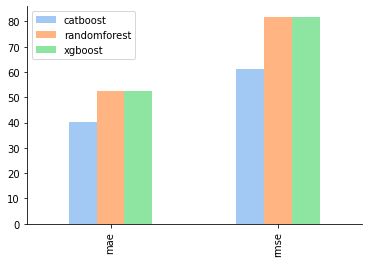

In [67]:
error_rec = {
    "catboost": {
        "mae": 40.29268484855883,
        "rmse": 61.19378120765249,
    },
    "randomforest": {
        "mae": 52.41012420250038,
        "rmse": 81.8514058171361,
    },
    "xgboost": {
        "mae": 52.41012420250038,
        "rmse": 81.8514058171361,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

Hyperparameter Tuning

Using CrossValidation on CatBoost

In [68]:
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits=5, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 59.7753929	test: 53.7633213	best: 53.7633213 (0)	total: 243ms	remaining: 2m 1s
75:	learn: 43.2726481	test: 41.0896523	best: 41.0896523 (75)	total: 18.6s	remaining: 1m 43s
150:	learn: 37.5436972	test: 38.7957695	best: 38.7942667 (148)	total: 36s	remaining: 1m 23s
225:	learn: 35.0348664	test: 38.2140780	best: 38.2140780 (225)	total: 52.8s	remaining: 1m 3s
300:	learn: 33.1862725	test: 37.9498933	best: 37.9498933 (300)	total: 1m 9s	remaining: 45.9s
375:	learn: 31.7230654	test: 37.7357839	best: 37.7357839 (375)	total: 1m 25s	remaining: 28s
450:	learn: 30.0735259	test: 37.5582692	best: 37.5582692 (450)	total: 1m 43s	remaining: 11.3s
499:	learn: 29.0588685	test: 37.3215688	best: 37.3215688 (499)	total: 1m 54s	remaining: 0us

bestTest = 37.32156876
bestIteration = 499



1it [01:55, 115.32s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.109138143884084


0:	learn: 59.2334360	test: 55.9653410	best: 55.9653410 (0)	total: 235ms	remaining: 1m 57s
75:	learn: 43.6426427	test: 42.6666263	best: 42.6666263 (75)	total: 17.3s	remaining: 1m 36s
150:	learn: 38.3124016	test: 39.2676330	best: 39.2676330 (150)	total: 34s	remaining: 1m 18s
225:	learn: 35.8510820	test: 38.1450117	best: 38.1450117 (225)	total: 50.9s	remaining: 1m 1s
300:	learn: 33.9065901	test: 37.5065935	best: 37.5065935 (300)	total: 1m 8s	remaining: 45.4s
375:	learn: 32.5131346	test: 37.0712269	best: 37.0712269 (375)	total: 1m 25s	remaining: 28.1s
450:	learn: 30.9165744	test: 36.5616460	best: 36.5615520 (448)	total: 1m 41s	remaining: 11.1s
499:	learn: 29.7350496	test: 36.0415415	best: 36.0415415 (499)	total: 1m 53s	remaining: 0us

bestTest = 36.04154152
bestIteration = 499



2it [03:48, 114.18s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.003460772420741


0:	learn: 56.9945821	test: 64.6569736	best: 64.6569736 (0)	total: 234ms	remaining: 1m 56s
75:	learn: 41.6238535	test: 52.6085867	best: 52.6085867 (75)	total: 16.5s	remaining: 1m 31s
150:	learn: 36.3613994	test: 49.1733654	best: 49.1733654 (150)	total: 32.9s	remaining: 1m 16s
225:	learn: 33.7498871	test: 47.9007204	best: 47.9007204 (225)	total: 51.1s	remaining: 1m 1s
300:	learn: 32.0381739	test: 46.8813253	best: 46.8813253 (300)	total: 1m 7s	remaining: 44.4s
375:	learn: 30.5774836	test: 46.2600946	best: 46.2600946 (375)	total: 1m 23s	remaining: 27.5s
450:	learn: 29.2692150	test: 45.7198527	best: 45.7198527 (450)	total: 1m 39s	remaining: 10.8s
499:	learn: 28.1819276	test: 45.2779928	best: 45.2779928 (499)	total: 1m 50s	remaining: 0us

bestTest = 45.27799276
bestIteration = 499



3it [05:39, 112.62s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.728892370719796


0:	learn: 59.9510498	test: 52.8644702	best: 52.8644702 (0)	total: 232ms	remaining: 1m 55s
75:	learn: 44.1779444	test: 39.6005609	best: 39.6005609 (75)	total: 18.5s	remaining: 1m 43s
150:	learn: 38.3921986	test: 36.8233002	best: 36.8233002 (150)	total: 35.4s	remaining: 1m 21s
225:	learn: 35.7183127	test: 35.9313967	best: 35.9313967 (225)	total: 51.8s	remaining: 1m 2s
300:	learn: 33.8375018	test: 35.4724489	best: 35.4723106 (299)	total: 1m 7s	remaining: 44.6s
375:	learn: 32.2472417	test: 35.0984822	best: 35.0984822 (375)	total: 1m 23s	remaining: 27.4s
450:	learn: 30.8311577	test: 34.8112947	best: 34.8025080 (442)	total: 1m 39s	remaining: 10.8s


4it [07:31, 112.37s/it]

499:	learn: 29.6551379	test: 34.4310527	best: 34.4307351 (498)	total: 1m 51s	remaining: 0us

bestTest = 34.43073507
bestIteration = 498

Shrink model to first 499 iterations.
out-of-folds prdiction ==== fold_3 RMSE 5.867770894451416


0:	learn: 56.9535275	test: 64.8356971	best: 64.8356971 (0)	total: 233ms	remaining: 1m 56s
75:	learn: 41.0374387	test: 53.1798669	best: 53.1798669 (75)	total: 17.6s	remaining: 1m 38s
150:	learn: 35.5554154	test: 50.5542576	best: 50.5542576 (150)	total: 34.6s	remaining: 1m 20s
225:	learn: 32.7065921	test: 49.5009323	best: 49.5009323 (225)	total: 51.5s	remaining: 1m 2s
300:	learn: 30.9369895	test: 48.9224505	best: 48.9224505 (300)	total: 1m 8s	remaining: 45.4s
375:	learn: 29.3567794	test: 48.5372345	best: 48.5371558 (374)	total: 1m 27s	remaining: 28.8s
450:	learn: 27.9165407	test: 48.1841276	best: 48.1840092 (449)	total: 1m 44s	remaining: 11.4s
499:	learn: 26.9166501	test: 47.7659116	best: 47.7659116 (499)	total: 1m 55s	remaining: 0us

bestTest = 47.76591155
bestIteration = 499



5it [09:27, 113.54s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.911288731685941


Using Optuna with Random Forest

In [69]:
# cross validating training data
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def random_forest_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()

In [70]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [71]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

[I 2022-08-07 19:09:05,719] A new study created in memory with name: no-name-15ea53ff-c19a-4ada-909e-df872ce44b07
[I 2022-08-07 19:13:37,967] Trial 0 finished with value: -35.535440517733164 and parameters: {'n_estimators': 384, 'max_depth': 15, 'min_samples_split': 7, 'max_features': 0.7838936250300762}. Best is trial 0 with value: -35.535440517733164.


Best score: -35.535440517733164
Optimized parameters: {'n_estimators': 384, 'max_depth': 15, 'min_samples_split': 7, 'max_features': 0.7838936250300762}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
CPU times: user 4min 33s, sys: 390 ms, total: 4min 33s
Wall time: 4min 32s


In [72]:
rf_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features=0.7838936250300762,
                      min_samples_split=7, n_estimators=384)

Final Evaluation

Text(0.5, 0, 'iteration')

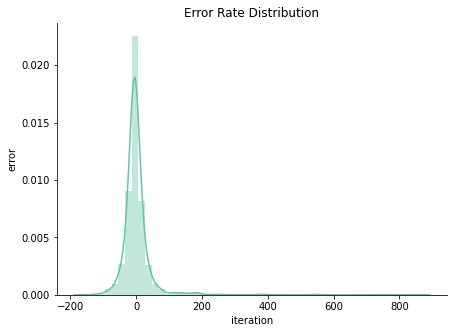

In [73]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

Text(0.5, 0, 'iteration')

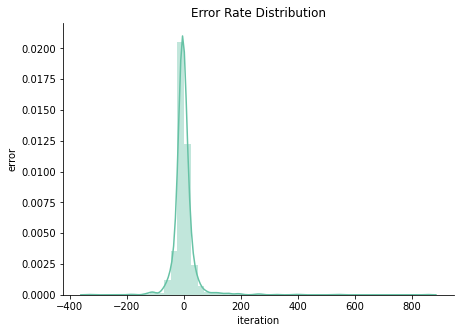

In [74]:
y_hat_tuned = rf_tuned_model.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

In [76]:
with open('rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [77]:
## Load models here
load = False
if load:
    with open('rf_tuned_final.joblib', 'rb') as f:
        rf = joblib.load(f)

    with open('catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)

Explainable AI

In [113]:
size = 200

sample_exists = False

if sample_exists:
    sample_set = pd.read_csv('sample2000.csv')
else:
    sample_set = X_test.sample(200)
sample_set

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
3695          6.0    136728.0      1988.0                79.0       45.7   
2225          5.0     16855.0      1965.0                44.0        9.1   
5816          5.0     49100.0      1911.0                21.0      115.8   
2295          5.0     18500.0      1935.0                97.0       59.1   
2765          5.0     36000.0      1907.0                65.0        9.1   
...           ...         ...         ...                 ...        ...   
537           3.0     17039.0      1907.0               100.0        6.1   
6927          4.0    178293.0      1983.0                82.0      100.6   
7952          4.0     60885.0      1939.0                85.0        3.0   
915           3.0     67314.0      1907.0               100.0      123.7   
255           5.0     50700.0      1919.0               100.0        9.1   

      january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
3695              37.0         52.693548              62.0               42.0   
2225              29.0         51.387097              77.0               36.0   
5816               8.0         29.966667              49.0                2.0   
2295              29.0         51.387097              77.0               36.0   
2765              29.0         51.387097              77.0               36.0   
...                ...               ...               ...                ...   
537               22.0         43.983871              66.0               29.0   
6927               3.0         28.290323              59.0               13.0   
7952               3.0         28.290323              59.0               13.0   
915               39.0         55.822581              80.0               44.0   
255               29.0         51.387097              77.0               36.0   

      february_avg_temp  february_max_temp  march_min_temp  march_avg_temp  \
3695          56.948276               75.0            47.0       57.725806   
2225          56.803571               75.0            40.0       61.435484   
5816          25.018519               64.0             9.0       38.448276   
2295          56.803571               75.0            40.0       61.435484   
2765          56.803571               75.0            40.0       61.435484   
...                 ...                ...             ...             ...   
537           49.410714               74.0            34.0       56.338710   
6927          34.107143               68.0             7.0       37.951613   
7952          34.107143               68.0             7.0       37.951613   
915           56.303571               78.0            48.0       60.112903   
255           56.803571               75.0            40.0       61.435484   

      march_max_temp  april_min_temp  april_avg_temp  april_max_temp  \
3695            76.0            47.0       60.283333            86.0   
2225            85.0            41.0       60.966667            91.0   
5816            74.0            32.0       55.379310            81.0   
2295            85.0            41.0       60.966667            91.0   
2765            85.0            41.0       60.966667            91.0   
...              ...             ...             ...             ...   
537             78.0            41.0       64.050000            93.0   
6927            70.0            31.0       54.450000            84.0   
7952            70.0            31.0       54.450000            84.0   
915             80.0            52.0       61.833333            79.0   
255             85.0            41.0       60.966667            91.0   

      may_min_temp  may_avg_temp  may_max_temp  june_min_temp  june_avg_temp  \
3695          51.0     61.064516          87.0           51.0      63.350000   
2225          45.0     62.887097          90.0           55.0      72.983333   
5816          47.0     69.706897          90.0           56.0      75.034483  

In [114]:
sample_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 3695 to 255
Columns: 162 entries, Year_Factor to floor_energy_star_rating
dtypes: float64(157), int64(5)
memory usage: 254.7 KB


calculate shap values

In [115]:
is_saved = False

if is_saved:
    with open('shap_values_sample2000.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(rf_tuned_model).shap_values(sample_set)

In [116]:
shap.initjs()

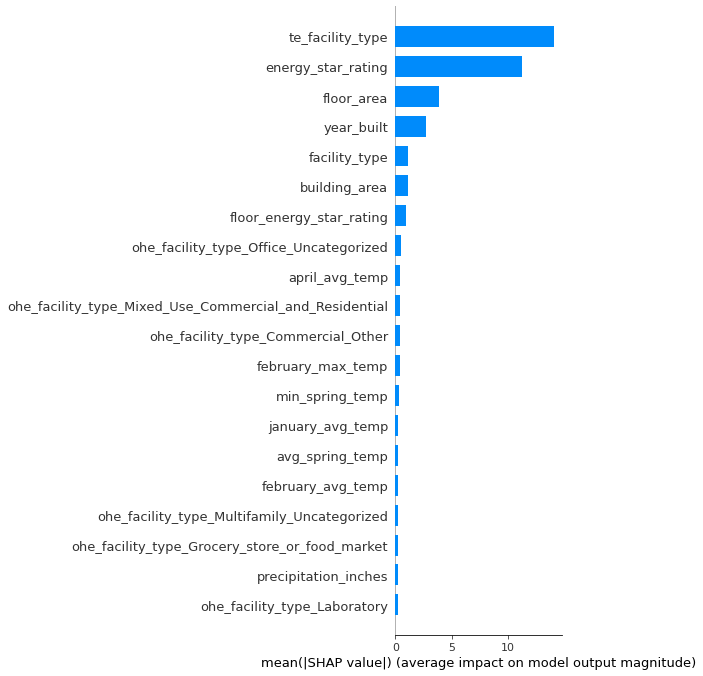

In [117]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

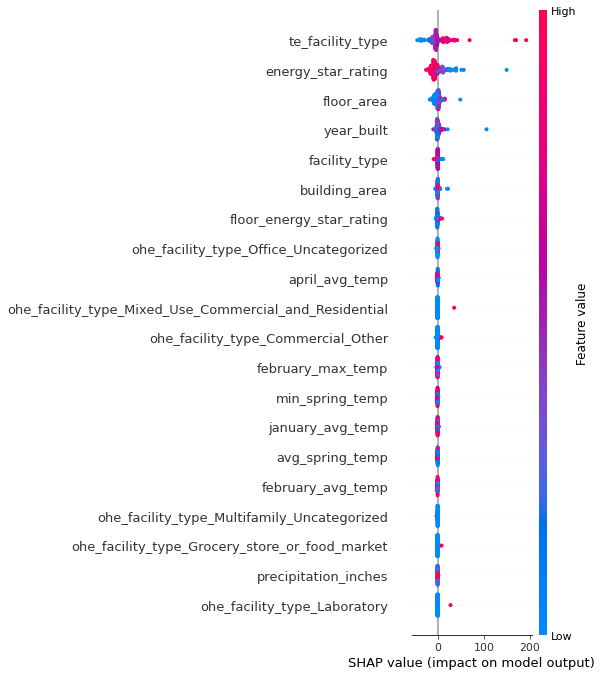

In [118]:
shap.summary_plot(shap_values, sample_set)

In [119]:
shap.initjs()
limit = 200
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[0:limit,:], sample_set.iloc[0:limit,:])

In [120]:

row = 60
print(y_pred[row])
shap.initjs()
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[row], sample_set.iloc[row])

52.483337


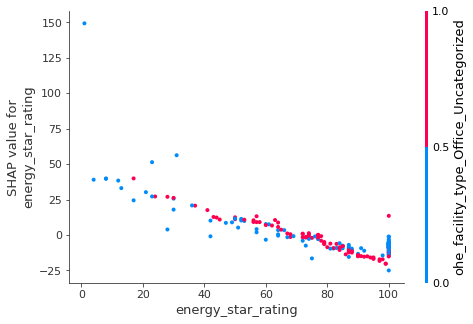

In [121]:
shap.dependence_plot('energy_star_rating', shap_values, sample_set)

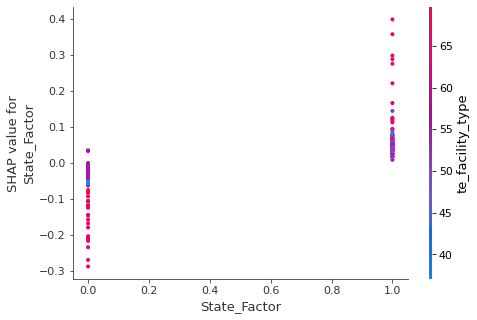

In [122]:
shap.dependence_plot('State_Factor', shap_values, sample_set)

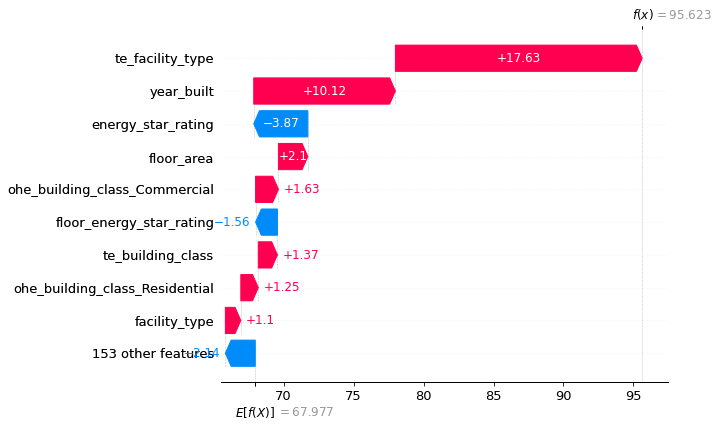

In [123]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=sample_set.columns.tolist()
                                      )

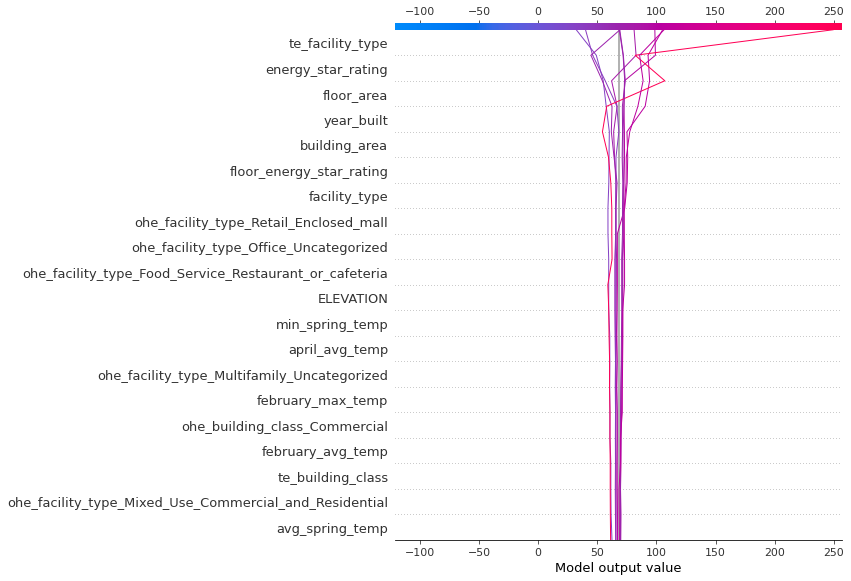

In [124]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=sample_set.columns.tolist())

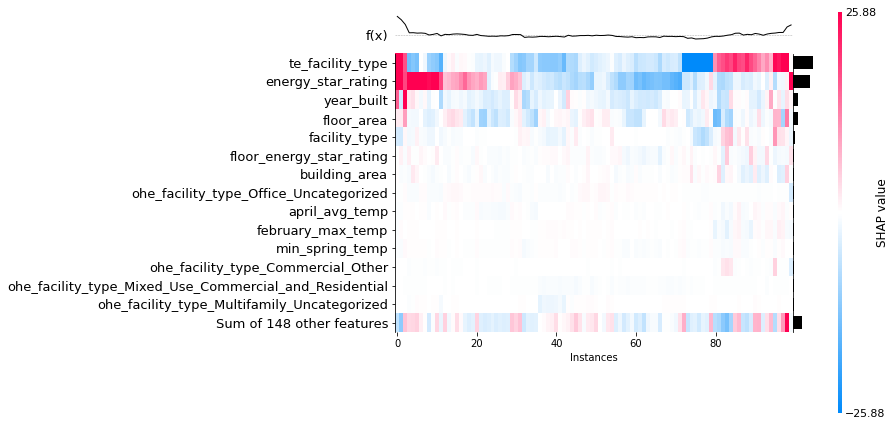

In [125]:
limit = 100
shap.plots.heatmap(shap.TreeExplainer(rf_tuned_model, data=sample_set)(sample_set[:limit]), max_display=15)